In [1]:
import torch
# from transformers import OPTForCausalLM, AutoModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer
# from chemlactica.utils.utils import get_tokenizer
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from rdkit.Chem import RDConfig, QED

from rdkit.Chem.rdMolDescriptors import CalcTPSA
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from sklearn.metrics import mean_squared_error


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066")
orig_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
cus_tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLactica/chemlactica/tokenizer/GemmaTokenizer")

In [3]:
orig_tokenizer.add_bos_token = False

In [4]:
# model_path = "/auto/home/menuab/code/checkpoints/9954e52e400b43d18d3a40f6/125m_122k_9954"
# model_path = "/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/"
model_path = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/d779400877344b57b495c8f2/last"
model_path = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/504e413cfff2463db5dd37e4/last"
model_path = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/8f4502ae5c354475be62125d/checkpoint-8000"
model_2b_16k_a3f8 = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/a3f81bf063a14e8289ed0c0c/checkpoint-16000/"
# OPTForCausalLM.__init__ = cast_lm_head_to_fp32_init(OPTForCausalLM.__init__)
model = AutoModelForCausalLM.from_pretrained(model_2b_16k_a3f8,torch_dtype=torch.float16).eval().to('cuda:1')
# model = 

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


In [7]:
prompt = f"what is the weight of aspirin"
len_prompt = len(prompt)
prompt = cus_tokenizer(prompt, return_tensors="pt").to(model.device)
out = model.generate(prompt.input_ids, do_sample=False, max_length=300)
out = cus_tokenizer.batch_decode(out)[0]
out

'what is the weight of aspirin.[/PROPERTY][PROPERTY]GHS Classification P261: Avoid breathing dust/fume/gas/mist/vapors/spray.[/PROPERTY][PROPERTY]GHS Classification P264: Wash hands [and …] thoroughly after handling.[/PROPERTY][PROPERTY]GHS Classification P264+P265: Wash hands [and …] thoroughly after handling. Do not touch eyes.[/PROPERTY][PROPERTY]GHS Classification P271: Use only outdoors or in a well-ventilated area.[/PROPERTY][PROPERTY]GHS Classification P280: Wear protective gloves/protective clothing/eye protection/face protection/hearing protection/...[/PROPERTY][PROPERTY]GHS Classification P302+P352: IF ON SKIN: wash with plenty of water/...[/PROPERTY][PROPERTY]GHS Classification P304+P340: IF INHALED: Remove person to fresh air and keep comfortable for breathing.[/PROPERTY][PROPERTY]GHS Classification P305+P351+P338: IF IN EYES: Rinse cautiously with water for several minutes. Remove contact lenses if present and easy to do - continue rinsing.[/PROPERTY][PROPERTY]GHS Classifi

In [8]:
prompt = f"<bos>[QED]0.23[/QED]"
len_prompt = len(prompt)
cus_tokenizer(prompt, return_tensors="pt")

{'input_ids': tensor([[     2,     18, 235276, 235265, 235284, 235304,     52]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [19]:
for i in range(0, len(out), 120):
    print(out[i:i+120])

</s>[START_SMILES]CC(C)(C)OC(=O)N1CCCC1C(=O)N1CCCC1C(=O)NC(Cc1ccc(O)cc1)C(=O)O[END_SMILES][SIMILAR]CC(C)CC(NC(=O)C(Cc1cc
c(O)cc1)NC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CCCN=C(N)N)NC(=O)C(CCCCN)NC(=O)C(CCCCN)NC(=O)C(N)CCCCN)C(=O)O 0.269709543
5684647[/SIMILAR][SIMILAR]CC(C)CC(NC(=O)C(Cc1ccc(O)cc1)NC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CCCN=C(N)N)NC(=O)C(CCCCN)N
C(=O)C(N)CCCCN)C(=O)O 0.30985915492957744[/SIMILAR][SIMILAR]CC(


In [13]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,100, 1):
    prompt = f"<bos>[TPSA]{i:.2f}[/TPSA]"
    len_prompt = len(prompt)
    prompt = cus_tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = cus_tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            tpsa_score = round(AllChem.CalcTPSA(Chem.MolFromSmiles(smiles)), 2)
            diff = abs(i - tpsa_score)
            print("GT:", i, "Gen:", tpsa_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(tpsa_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

GT: 0 Gen: 0.0 diff: 0.0 CC1=C(C)C(C)C([Si](C)(C)C2C(C)=C(C)C(C)=C2C)=C1C <bos>[TPSA]0.00[/TPSA][NUMROTATABLEBONDS]1[/NUMROTATABLEBONDS][RINGCOUNT]2[/RINGCOUNT][START_SMILES]CC1=C(C)C(C)C([Si](C)(C)C2C(C)=C(C)C(C)=C2C)=C1C[END_SMILES][NHOHCOUNT]0[/NHOHCOUNT][FORMULA]C21H34Si[/FORMULA][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NOCOUNT]0[/NOCOUNT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHACCEPTORS]
GT: 1 Gen: 3.24 diff: 2.24 CC(C)C1CCCN(CC2CC2)CC1 <bos>[TPSA]1.00[/TPSA][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][START_SMILES]CC(C)C1CCCN(CC2CC2)CC1[END_SMILES][NHOHCOUNT]0[/NHOHCOUNT][RINGCOUNT]2[/RINGCOUNT][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][NUMALIPHATICRINGS]2[/NUMALIPHATICRINGS][CLOGP]3.40[/CLOGP][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NOCOUNT]1[/NOCOUNT][NUMHDONORS]0[/NUMHDONORS][NUMAROMATICRINGS]0[/NUMAROMATICRINGS][NUMAROMATICCARBOCYCLES]0[/NUMAROMATICCARBOCYCLES][NUMHACCEPTORS]
GT: 2 Gen: 0.0 diff: 2.0 CC1(C)C(C(Br)c2cc(Br)

In [ ]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,100),(0,100))
plt.title(f"tpsa {rmse=}")
plt.grid(True)


12.459650836985436


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,1, 0.01):
    prompt = f"<bos>[QED]{i:.2f}[/QED][START_SMILES]"
    len_prompt = len(prompt)
    prompt = cus_tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, max_length=300)
    out = cus_tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            qed_score = round(qed_score, 2)
            diff = abs(i - qed_score)
            print(out, '\n')
            print("GT:", i, "Gen:", qed_score, "diff:", round(diff,2), smiles )
            ground_truths.append(i)
            gens.append(qed_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

GT: 0.0 <bos>[QED]0.00[/QED][START_SMILES]CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

In [34]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,1, 0.01):
    prompt = f"</s>[QED]{i:.2f}[/QED]"
    len_prompt = len(prompt)
    prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            qed_score = round(qed_score, 2)
            diff = abs(i - qed_score)
            print("GT:", i, "Gen:", qed_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(qed_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

GT: 0.0 Gen: 0.39 diff: 0.39 CC(C)C(C)NC(=O)C(C)N(Cc1ccccc1)C(=O)CN(c1ccc(F)cc1)S(=O)(=O)c1ccccc1 </s>[QED]0.00[/QED][CLOGP]1.66[/CLOGP][FORMULA]C10H11N3O2S[/FORMULA][HEAVYATOMCOUNT]16[/HEAVYATOMCOUNT][FRACTIONCSP3]0.25[/FRACTIONCSP3][NUMSATURATEDCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][TPSA]75.01[/TPSA][IUPAC]N-(2-amino-2-oxoethyl)-5-methyl-1,3-thiazol-4-amine[/IUPAC][QED]0.68[/QED][NOCOUNT]5[/NOCOUNT]<bos>[START_SMILES]CC(C)C(C)NC(=O)C(C)N(Cc1ccccc1)C(=O)CN(c1ccc(F)cc1)S(=O)(=O)c1ccccc1[END_SMILES][RINGCOUNT]3[/RINGCOUNT][FORMULA]C29H35FN4O4S[/FORMULA][SIMILAR]CC(C)C(C)NC(=O)C(C)N(Cc1ccccc1)C(=O)CN(c1ccc(F)cc1)S(=O)(=O)c1ccccc1 0.94[/SIMILAR][SIMILAR]CC(C)C(C)NC(=O)C(C)N(Cc1ccccc1)C(=O)CN(c1ccc(F)cc1)S(=O)(=O)c1ccccc1 0.94[/SIMILAR][SIMILAR]CC(C)C(C)NC(=O)C(C)N(Cc1ccccc1)C(=O)CN(c1ccc(F)
GT: 0.01 Gen: 0.39 diff: 0.38 CC(C)C(C)NC(=O)C(C)N(Cc1ccccc1)C(=O)CN(c1ccc(F)cc1)S(=O)(=O)c1ccccc1 </s>[QED]0.01[/QED][CLOGP]1.66[/CLOGP][FORMULA]C10H11N3O2S[/FORMULA][HEAVYATOMCOUNT]16[/HEAVYATOMCOUN

0.30862685825185177


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


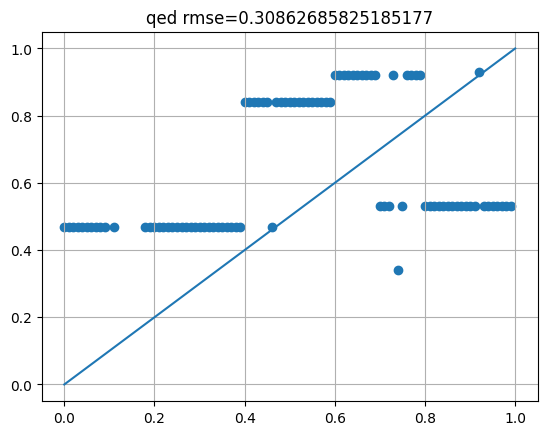

In [50]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,1),(0,1))
plt.title(f"qed {rmse=}")
plt.grid(True)

0.3806411949569379


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


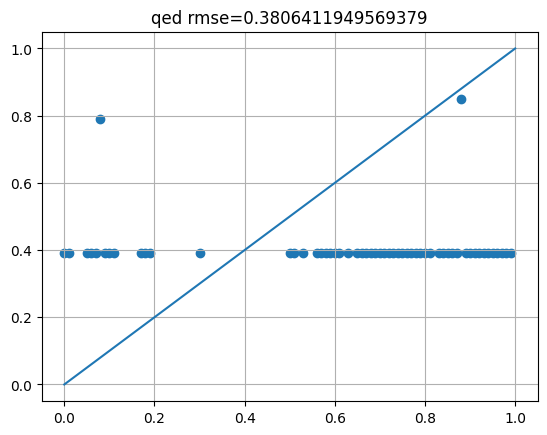

In [35]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,1),(0,1))
plt.title(f"qed {rmse=}")
plt.grid(True)

In [ ]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(1,10, 0.1):
    prompt = f"<bos>[SAS]{i:.2f}[/SAS]"
    len_prompt = len(prompt)
    prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            # qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            sas_score = round(sascorer.calculateScore(Chem.MolFromSmiles(smiles)), 2)
            diff = abs(i - sas_score)
            print("GT:", i, "Gen:", sas_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(sas_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

In [ ]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)